## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False, l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 182us/step - loss: 1.8825 - accuracy: 0.3554 - val_loss: 1.7492 - val_accuracy: 0.3785
Epoch 2/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.5438 - accuracy: 0.4564 - val_loss: 1.6353 - val_accuracy: 0.4218
Epoch 3/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.4444 - accuracy: 0.4922 - val_loss: 1.5480 - val_accuracy: 0.4512
Epoch 4/10
50000/50000 [==============================] - 8s 161us/step - loss: 1.3732 - accuracy: 0.5176 - val_loss: 1.4739 - val_accuracy: 0.4780
Epoch 5/10
50000/50000 [==============================] - 8s 161us/step - loss: 1.3142 - accuracy: 0.5364 - val_loss: 1.5228 - val_accuracy: 0.4726
Epoch 6/10
50000/50000 [==============================] - 8s 168us/step - loss: 1.2643 - accuracy: 0.5561 - val_loss: 1.4892 - val_accuracy: 0.4762 - loss: 1
Epoch 7/10
50000/50000 [============================

50000/50000 [==============================] - 8s 162us/step - loss: 1.0897 - accuracy: 0.6199 - val_loss: 1.5613 - val_accuracy: 0.4543
Experiment with L1 = 0.000100, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.8589 - accuracy: 0.3623 - val_loss: 1.7357 - val_accuracy: 0.3900
Epoch 2/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.5394 - accuracy: 0.4578 - val_loss: 1.6181 - val_accuracy: 0.4252
Epoch 3/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.4378 - accuracy: 0.4958 - val_loss: 1.5291 - val_accuracy: 0.4577
Epoch 4/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.3655 - accuracy: 0.5217 - val_loss: 1.4891 - val_accuracy: 0.4714
Epoch 5/10
50000/50000 [==============================] - 8s 165us/step - loss: 1.3027 - accuracy: 0.5431 - val_loss: 1.5300 - val_accuracy: 0.4630
Epoch 6/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.2565 - accuracy: 0.5591 - val_loss: 1.5276 - val_accuracy: 0.4574
Epoch 7/10
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 8s 163us/step - loss: 1.0923 - accuracy: 0.6182 - val_loss: 1.4705 - val_accuracy: 0.4838
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.8690 - accuracy: 0.3570 - val_loss: 1.7215 - val_accuracy: 0.4022
Epoch 2/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.5461 - accuracy: 0.4552 - val_loss: 1.5922 - val_accuracy: 0.4315
Epoch 3/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.4388 - accuracy: 0.4972 - val_loss: 1.5409 - val_accuracy: 0.4573
Epoch 4/10
50000/50000 [==============================] - 8s 165us/step - loss: 1.3686 - accuracy: 0.5207 - val_loss: 1.5317 - val_accuracy: 0.4602
Epoch 5/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.3096 - accuracy: 0.5420 - val_loss: 1.5537 - val_accuracy: 0.4486
Epoch 6/10
50000/50000 [==============================] - 8s 164us/step - loss: 1.2559 - accuracy: 0.5626 - val_loss: 1.4945 - val_accuracy: 0.4654
Epoch 7/10
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 10s 192us/step - loss: 1.0923 - accuracy: 0.6177 - val_loss: 1.5537 - val_accuracy: 0.4658
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activati

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 210us/step - loss: 1.8634 - accuracy: 0.3567 - val_loss: 1.7388 - val_accuracy: 0.3871
Epoch 2/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.5355 - accuracy: 0.4604 - val_loss: 1.6129 - val_accuracy: 0.4266
Epoch 3/10
50000/50000 [==============================] - 8s 166us/step - loss: 1.4358 - accuracy: 0.4943 - val_loss: 1.5600 - val_accuracy: 0.4439
Epoch 4/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.3621 - accuracy: 0.5207 - val_loss: 1.5347 - val_accuracy: 0.4550
Epoch 5/10
50000/50000 [==============================] - 9s 175us/step - loss: 1.3056 - accuracy: 0.5405 - val_loss: 1.5030 - val_accuracy: 0.4662
Epoch 6/10
50000/50000 [==============================] - 8s 169us/step - loss: 1.2519 - accuracy: 0.5621 - val_loss: 1.4760 - val_accuracy: 0.4790
Epoch 7/10
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 165us/step - loss: 1.0885 - accuracy: 0.6214 - val_loss: 1.4350 - val_accuracy: 0.4949
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activatio

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 192us/step - loss: 1.8761 - accuracy: 0.3517 - val_loss: 1.7918 - val_accuracy: 0.3552
Epoch 2/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.5525 - accuracy: 0.4545 - val_loss: 1.6387 - val_accuracy: 0.4136
Epoch 3/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.4453 - accuracy: 0.4928 - val_loss: 1.5999 - val_accuracy: 0.4203
Epoch 4/10
50000/50000 [==============================] - 8s 167us/step - loss: 1.3733 - accuracy: 0.5169 - val_loss: 1.6161 - val_accuracy: 0.4346
Epoch 5/10
50000/50000 [==============================] - 8s 168us/step - loss: 1.3101 - accuracy: 0.5415 - val_loss: 1.4999 - val_accuracy: 0.4753
Epoch 6/10
50000/50000 [==============================] - 8s 168us/step - loss: 1.2574 - accuracy: 0.5586 - val_loss: 1.4977 - val_accuracy: 0.4709
Epoch 7/10
50000/50000 [==============================] - 8s 

50000/50000 [==============================] - 8s 166us/step - loss: 1.0970 - accuracy: 0.6179 - val_loss: 1.5037 - val_accuracy: 0.4858


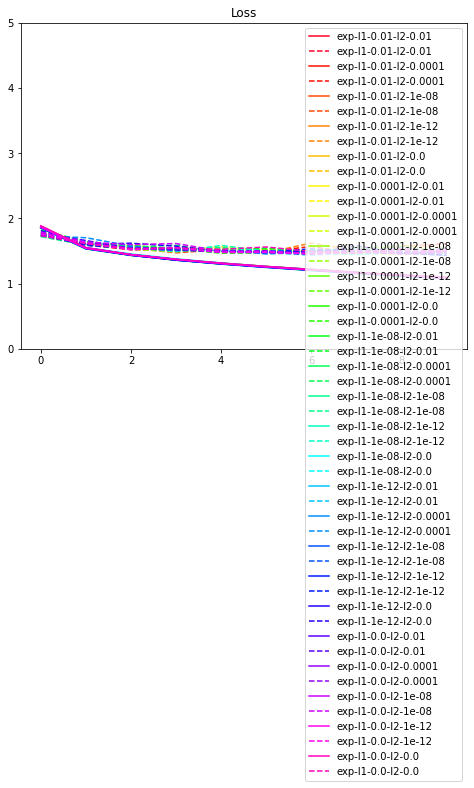

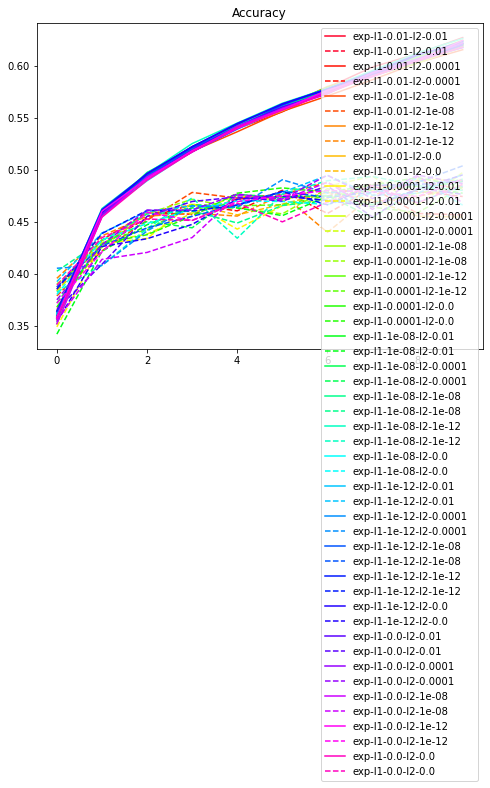

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False, l1_ratio=0.0, l2_ratio=0.0,drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
PRE_ACTIVATE = [True, False]

In [15]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 220us/step - loss: 1.8644 - accuracy: 0.3562 - val_loss: 1.7464 - val_accuracy: 0.3784
Epoch 2/10
50000/50000 [==============================] - 9s 184us/step - loss: 1.5439 - accuracy: 0.4576 - val_loss: 1.5853 - val_accuracy: 0.4387
Epoch 3/10
50000/50000 [==============================] - 9s 185us/step - loss: 1.4432 - accuracy: 0.4918 - val_loss: 1.5707 - val_accuracy: 0.4414
Epoch 4/10
50000/50000 [==============================] - 9s 185us/step - loss: 1.3673 - accuracy: 0.5181 - val_loss: 1.5264 - val_accuracy: 0.4570
Epoch 5/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.3096 - accuracy: 0.5397 - val_loss: 1.4831 - val_accuracy: 0.4734
Epoch 6/10
50000/50000 [==============================] - 9s 186us/step - loss: 1.2619 - accuracy: 0.5575 - val_loss: 1.5189 - val_accuracy: 0.4641
Epoch 7/10
50000/50000 [==============================] - 9s 

50000/50000 [==============================] - 10s 202us/step - loss: 1.1289 - accuracy: 0.6052 - val_loss: 1.4818 - val_accuracy: 0.4808
Epoch 10/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.0890 - accuracy: 0.6192 - val_loss: 1.5174 - val_accuracy: 0.4738
Experiment with L1 = 0.000100, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 235us/step - loss: 1.8679 - accuracy: 0.3604 - val_loss: 1.7592 - val_accuracy: 0.3785
Epoch 2/10
50000/50000 [==============================] - 10s 196us/step - loss: 1.5448 - accuracy: 0.4588 - val_loss: 1.6174 - val_accuracy: 0.4281
Epoch 3/10
50000/50000 [==============================] - 10s 196us/step - loss: 1.4458 - accuracy: 0.4917 - val_loss: 1.5635 - val_accuracy: 0.4516
Epoch 4/10
50000/50000 [==============================] - 10s 197us/step - loss: 1.3709 - accuracy: 0.5193 - val_loss: 1.5184 - val_accuracy: 0.4612
Epoch 5/10
50000/50000 [==============================] - 10s 197us/step - loss: 1.3099 - accuracy: 0.5395 - val_loss: 1.4698 - val_accuracy: 0.4784
Epoch 6/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.2614 - accuracy: 0.5578 - val_loss: 1.4732 - val_accuracy: 0.4795y: 0.55
Epoch 7/10
50000/50000 [=========================

50000/50000 [==============================] - 10s 195us/step - loss: 1.1354 - accuracy: 0.6031 - val_loss: 1.5283 - val_accuracy: 0.4747ss: 1.1359 - accuracy
Epoch 10/10
50000/50000 [==============================] - 10s 195us/step - loss: 1.0948 - accuracy: 0.6182 - val_loss: 1.5116 - val_accuracy: 0.4747 accura - ETA: 0s - loss: 1.0
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
______

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 244us/step - loss: 1.8515 - accuracy: 0.3604 - val_loss: 1.7588 - val_accuracy: 0.3692
Epoch 2/10
50000/50000 [==============================] - 11s 215us/step - loss: 1.5540 - accuracy: 0.4540 - val_loss: 1.6259 - val_accuracy: 0.4171
Epoch 3/10
50000/50000 [==============================] - 10s 207us/step - loss: 1.4492 - accuracy: 0.4896 - val_loss: 1.5730 - val_accuracy: 0.4479
Epoch 4/10
50000/50000 [==============================] - 10s 202us/step - loss: 1.3764 - accuracy: 0.5174 - val_loss: 1.5300 - val_accuracy: 0.4557
Epoch 5/10
50000/50000 [==============================] - 10s 206us/step - loss: 1.3214 - accuracy: 0.5336 - val_loss: 1.5140 - val_accuracy: 0.4683
Epoch 6/10
50000/50000 [==============================] - 10s 209us/step - loss: 1.2642 - accuracy: 0.5563 - val_loss: 1.5148 - val_accuracy: 0.4703
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 10s 199us/step - loss: 1.1273 - accuracy: 0.6077 - val_loss: 1.5049 - val_accuracy: 0.4811
Epoch 10/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.0914 - accuracy: 0.6208 - val_loss: 1.4857 - val_accuracy: 0.4837
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 237us/step - loss: 1.8752 - accuracy: 0.3522 - val_loss: 1.7473 - val_accuracy: 0.3834
Epoch 2/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.5480 - accuracy: 0.4573 - val_loss: 1.5984 - val_accuracy: 0.4350
Epoch 3/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.4462 - accuracy: 0.4908 - val_loss: 1.5656 - val_accuracy: 0.4478
Epoch 4/10
50000/50000 [==============================] - 10s 200us/step - loss: 1.3701 - accuracy: 0.5189 - val_loss: 1.5422 - val_accuracy: 0.4525
Epoch 5/10
50000/50000 [==============================] - 10s 201us/step - loss: 1.3084 - accuracy: 0.5397 - val_loss: 1.4915 - val_accuracy: 0.4686
Epoch 6/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.2561 - accuracy: 0.5575 - val_loss: 1.4934 - val_accuracy: 0.4793
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 10s 201us/step - loss: 1.1010 - accuracy: 0.6158 - val_loss: 1.5657 - val_accuracy: 0.4488
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activati

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.8514 - accuracy: 0.3624 - val_loss: 1.8068 - val_accuracy: 0.3545
Epoch 2/10
50000/50000 [==============================] - 10s 202us/step - loss: 1.5389 - accuracy: 0.4603 - val_loss: 1.6096 - val_accuracy: 0.4235
Epoch 3/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.4363 - accuracy: 0.4960 - val_loss: 1.5626 - val_accuracy: 0.4462
Epoch 4/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.3609 - accuracy: 0.5214 - val_loss: 1.5446 - val_accuracy: 0.4511
Epoch 5/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.3045 - accuracy: 0.5454 - val_loss: 1.4764 - val_accuracy: 0.4767
Epoch 6/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.2464 - accuracy: 0.5656 - val_loss: 1.4556 - val_accuracy: 0.4797
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 10s 203us/step - loss: 1.0900 - accuracy: 0.6205 - val_loss: 1.4935 - val_accuracy: 0.4761


In [16]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 247us/step - loss: 1.8589 - accuracy: 0.3629 - val_loss: 1.7306 - val_accuracy: 0.3889A:  -
Epoch 2/10
50000/50000 [==============================] - 11s 213us/step - loss: 1.5398 - accuracy: 0.4602 - val_loss: 1.6179 - val_accuracy: 0.4232
Epoch 3/10
50000/50000 [==============================] - 11s 215us/step - loss: 1.4372 - accuracy: 0.4961 - val_loss: 1.5463 - val_accuracy: 0.4527
Epoch 4/10
50000/50000 [==============================] - 11s 216us/step - loss: 1.3651 - accuracy: 0.5224 - val_loss: 1.5196 - val_accuracy: 0.4658
Epoch 5/10
50000/50000 [==============================] - 11s 217us/step - loss: 1.3022 - accuracy: 0.5423 - val_loss: 1.5297 - val_accuracy: 0.4581
Epoch 6/10
50000/50000 [==============================] - 11s 216us/step - loss: 1.2513 - accuracy: 0.5611 - val_loss: 1.4494 - val_accuracy: 0.4913
Epoch 7/10
50000/50000 [===========================

Epoch 10/10
50000/50000 [==============================] - 11s 220us/step - loss: 1.0845 - accuracy: 0.6221 - val_loss: 1.5352 - val_accuracy: 0.4706
Experiment with L1 = 0.000100, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 268us/step - loss: 1.8651 - accuracy: 0.3572 - val_loss: 1.7551 - val_accuracy: 0.3786
Epoch 2/10
50000/50000 [==============================] - 11s 217us/step - loss: 1.5402 - accuracy: 0.4603 - val_loss: 1.6000 - val_accuracy: 0.4330
Epoch 3/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.4367 - accuracy: 0.4962 - val_loss: 1.5105 - val_accuracy: 0.4707
Epoch 4/10
50000/50000 [==============================] - 11s 223us/step - loss: 1.3628 - accuracy: 0.5228 - val_loss: 1.5789 - val_accuracy: 0.4378
Epoch 5/10
50000/50000 [==============================] - 11s 223us/step - loss: 1.3037 - accuracy: 0.5427 - val_loss: 1.4899 - val_accuracy: 0.4687
Epoch 6/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.2511 - accuracy: 0.5633 - val_loss: 1.4765 - val_accuracy: 0.4728
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 11s 224us/step - loss: 1.0813 - accuracy: 0.6254 - val_loss: 1.6461 - val_accuracy: 0.4418
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activati

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 14s 274us/step - loss: 1.8686 - accuracy: 0.3575 - val_loss: 1.7409 - val_accuracy: 0.3854
Epoch 2/10
50000/50000 [==============================] - 12s 232us/step - loss: 1.5509 - accuracy: 0.4548 - val_loss: 1.5859 - val_accuracy: 0.4397
Epoch 3/10
50000/50000 [==============================] - 12s 232us/step - loss: 1.4480 - accuracy: 0.4935 - val_loss: 1.5342 - val_accuracy: 0.4613
Epoch 4/10
50000/50000 [==============================] - 12s 233us/step - loss: 1.3758 - accuracy: 0.5168 - val_loss: 1.5417 - val_accuracy: 0.4585- l
Epoch 5/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.3159 - accuracy: 0.5393 - val_loss: 1.5321 - val_accuracy: 0.4607
Epoch 6/10
50000/50000 [==============================] - 12s 232us/step - loss: 1.2617 - accuracy: 0.5551 - val_loss: 1.4718 - val_accuracy: 0.4776
Epoch 7/10
50000/50000 [=============================

50000/50000 [==============================] - 11s 227us/step - loss: 1.0800 - accuracy: 0.6217 - val_loss: 1.5358 - val_accuracy: 0.4711
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activati

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 14s 275us/step - loss: 1.8730 - accuracy: 0.3599 - val_loss: 1.8034 - val_accuracy: 0.3620
Epoch 2/10
50000/50000 [==============================] - 12s 231us/step - loss: 1.5446 - accuracy: 0.4605 - val_loss: 1.6099 - val_accuracy: 0.4303
Epoch 3/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.4436 - accuracy: 0.4921 - val_loss: 1.6314 - val_accuracy: 0.4186
Epoch 4/10
50000/50000 [==============================] - 12s 235us/step - loss: 1.3704 - accuracy: 0.5203 - val_loss: 1.5859 - val_accuracy: 0.4424
Epoch 5/10
50000/50000 [==============================] - 12s 237us/step - loss: 1.3150 - accuracy: 0.5394 - val_loss: 1.4834 - val_accuracy: 0.4758
Epoch 6/10
50000/50000 [==============================] - 12s 237us/step - loss: 1.2616 - accuracy: 0.5595 - val_loss: 1.4980 - val_accuracy: 0.4713
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 12s 241us/step - loss: 1.0944 - accuracy: 0.6204 - val_loss: 1.4929 - val_accuracy: 0.4776
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activati

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 292us/step - loss: 1.8648 - accuracy: 0.3593 - val_loss: 1.7472 - val_accuracy: 0.3819
Epoch 2/10
50000/50000 [==============================] - 13s 252us/step - loss: 1.5488 - accuracy: 0.4568 - val_loss: 1.6111 - val_accuracy: 0.4348
Epoch 3/10
50000/50000 [==============================] - 13s 251us/step - loss: 1.4471 - accuracy: 0.4939 - val_loss: 1.6107 - val_accuracy: 0.4311
Epoch 4/10
50000/50000 [==============================] - 13s 251us/step - loss: 1.3758 - accuracy: 0.5182 - val_loss: 1.5687 - val_accuracy: 0.4531A: 0s - loss: 1.3767 - accuracy: 
Epoch 5/10
50000/50000 [==============================] - 12s 250us/step - loss: 1.3127 - accuracy: 0.5409 - val_loss: 1.5092 - val_accuracy: 0.4629
Epoch 6/10
50000/50000 [==============================] - 12s 249us/step - loss: 1.2610 - accuracy: 0.5581 - val_loss: 1.5253 - val_accuracy: 0.4679
Epoch 7/10
50000/50000 

50000/50000 [==============================] - 12s 233us/step - loss: 1.1244 - accuracy: 0.6052 - val_loss: 1.4608 - val_accuracy: 0.4887
Epoch 10/10
50000/50000 [==============================] - 12s 235us/step - loss: 1.0853 - accuracy: 0.6213 - val_loss: 1.4880 - val_accuracy: 0.4773


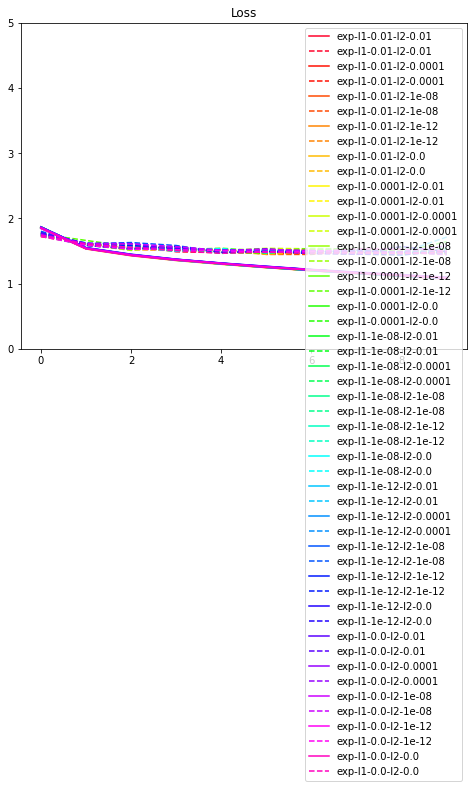

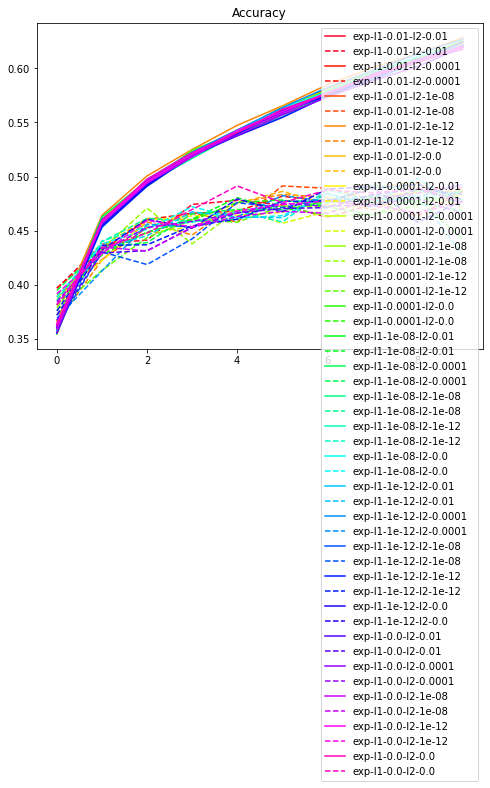

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()